In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
torch.manual_seed(0)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
dir_list = os.listdir('free-spoken-digit-dataset-master/recordings/')
print(f'Recordings : {dir_list[0:5]}')

Recordings : ['9_jackson_30.wav', '5_nicolas_41.wav', '7_george_15.wav', '7_jackson_8.wav', '4_jackson_26.wav']


In [4]:
path = []
labels = []
for i in dir_list:
    path.append('free-spoken-digit-dataset-master/recordings/'+str(i))
    labels.append(i.split('_')[0])
data = pd.DataFrame({'path':path,'label':labels})
data.to_csv('data_path.csv')

In [5]:
data.head()

,path,label
0,free-spoken-digit-dataset-master/recordings/9_...,9
1,free-spoken-digit-dataset-master/recordings/5_...,5
2,free-spoken-digit-dataset-master/recordings/7_...,7
3,free-spoken-digit-dataset-master/recordings/7_...,7
4,free-spoken-digit-dataset-master/recordings/4_...,4


In [6]:
df_X = pd.DataFrame(columns=['tensor','sr'])

tensors = []
srs = []
for i in data['path']:
    data_waveform, rate_of_sample = torchaudio.load(i)
    tensors.append(data_waveform)
    srs.append(rate_of_sample)
df_X['tensor'] = tensors
df_X['sr'] = srs
df_X = pd.concat([data,df_X],axis=1)
df_X=df_X.fillna(0)

In [7]:
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1, target_variable=None):
    assert (train_split + test_split + val_split) == 1
    
    df_sample = df.sample(frac=1, random_state=42)

    if target_variable is not None:
        grouped_df = df_sample.groupby(target_variable)
        arr_list = [np.split(g, [int(train_split * len(g)), int((1 - val_split) * len(g))]) for i, g in grouped_df]

        train_ds = pd.concat([t[0] for t in arr_list])
        val_ds = pd.concat([t[1] for t in arr_list])
        test_ds = pd.concat([v[2] for v in arr_list])

    else:
        indices_or_sections = [int(train_split * len(df)), int((1 - val_split) * len(df))]
        train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, test_ds, val_ds  = get_dataset_partitions_pd(df_X.drop(['path'],axis=1),train_split=0.8, val_split=0.1, test_split=0.1, target_variable='label')

In [9]:
print(f'train_ds.shape: {train_ds.shape}\n\n'+
      f'val_ds.shape: {val_ds.shape}\n\n'+
      f'test_ds.shape: {test_ds.shape}\n\n')

train_ds.shape: (2400, 3)

val_ds.shape: (300, 3)

test_ds.shape: (300, 3)




In [10]:
print(f'Distribution in training set: \n{train_ds.label.value_counts().sort_index() / len(train_ds)}\n\n'+
      f'Distribution in validation set: \n{val_ds.label.value_counts().sort_index() / len(val_ds)}\n\n'+
    f'Distribution in testing set: \n{test_ds.label.value_counts().sort_index() / len(test_ds)}')

Distribution in training set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64

Distribution in validation set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64

Distribution in testing set: 
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: label, dtype: float64


In [11]:
train_set = train_ds[['tensor', 'sr', 'label']].to_numpy()
validation_set = val_ds[['tensor', 'sr', 'label']].to_numpy()
test_set = test_ds[['tensor', 'sr', 'label']].to_numpy()

In [12]:
waveform0, sample_rate0, numclass0 = train_set[0]
waveform1, sample_rate1, numclass1 = validation_set[0]
waveform2, sample_rate2, numclass2 = test_set[0]

In [13]:
waveform2

tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]])

In [14]:
print('Sample of training set')
waveform0, sample_rate0, numclass0

Sample of training set


(tensor([[ 0.0005,  0.0002,  0.0003,  ..., -0.0005, -0.0002,  0.0001]]),
 8000,
 '0')

In [15]:
waveform0.shape

torch.Size([1, 4455])

In [16]:
print('Sample first entry of validation set')
waveform1, sample_rate1, numclass1

Sample first entry of validation set


(tensor([[-0.0101, -0.0121, -0.0153,  ..., -0.0081, -0.0084, -0.0098]]),
 8000,
 '0')

In [17]:
print('Sample first entry of test set')
waveform2, sample_rate2, numclass2

Sample first entry of test set


(tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]]),
 8000,
 '0')

In [18]:
print('Sample 500th entry of all sets\n')
train_set[200], validation_set[200], test_set[200]

Sample 500th entry of all sets



(array([tensor([[ 0.0000,  0.0003,  0.0001,  ..., -0.0005, -0.0005, -0.0002]]),
        8000, '0'], dtype=object),
 array([tensor([[ 0.0033, -0.0040,  0.0033,  ...,  0.0073,  0.0050,  0.0017]]),
        8000, '6'], dtype=object),
 array([tensor([[ 0.0000,  0.0000, -0.0156,  ..., -0.0078,  0.0000, -0.0078]]),
        8000, '6'], dtype=object))

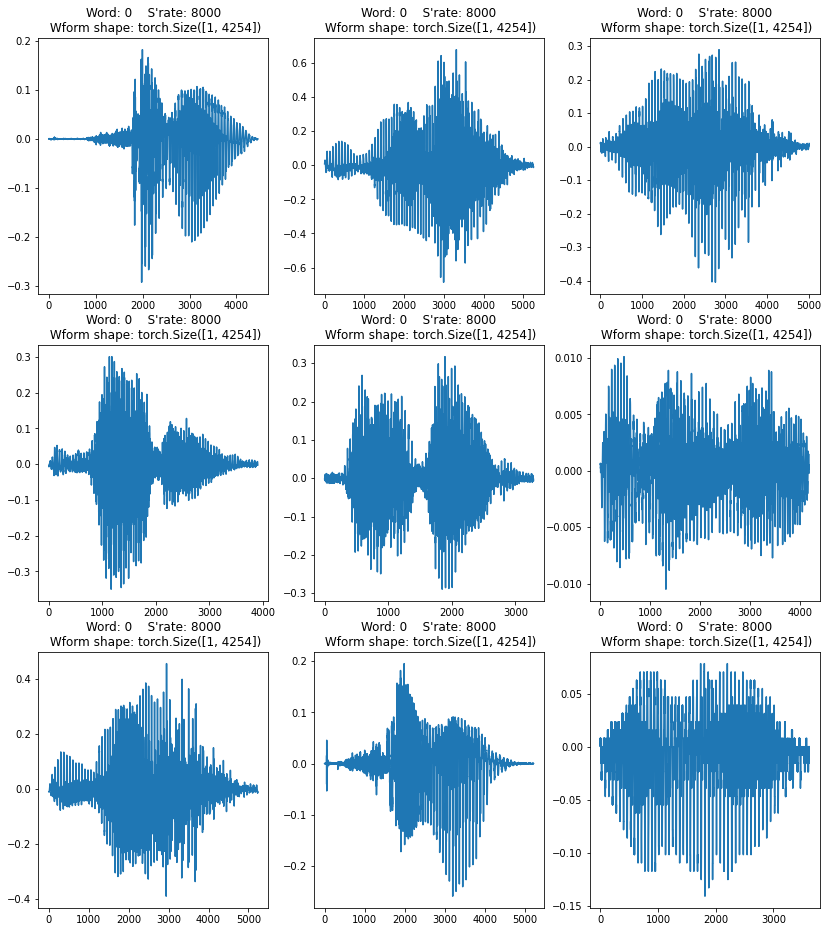

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 16))
for i in range (9):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(train_set[i][0].t().numpy())
    ax.set_title(f"Word: {test_set[i][2]}    S'rate: {test_set[i][1]}" + f'\n Wform shape: {waveform2.size()}')

plt.show()

In [20]:
numclasses = sorted(list(set(element[2] for element in train_set)))
numclasses

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [21]:
print('Total number of entries in training set :', (len(train_set)))
print('Total number of entries in validation set :', (len(validation_set)))
print('Total number of entries in test set :', (len(test_set)))

Total number of entries in training set : 2400
Total number of entries in validation set : 300
Total number of entries in test set : 300


In [22]:
print('Total number of entries in training set :', (len(train_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(train_set)):
        if (train_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in training set : 2400
Number of num class entries : 10

Num class : Count
0  : 240
1  : 240
2  : 240
3  : 240
4  : 240
5  : 240
6  : 240
7  : 240
8  : 240
9  : 240


In [23]:
print('Total number of entries in validation set :', (len(validation_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(validation_set)):
        if (validation_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in validation set : 300
Number of num class entries : 10

Num class : Count
0  : 30
1  : 30
2  : 30
3  : 30
4  : 30
5  : 30
6  : 30
7  : 30
8  : 30
9  : 30


In [24]:
print('Total number of entries in test set :', (len(test_set)))
print('Number of num class entries :', (len(numclasses)))
print('\nNum class : Count')
for j in range (len(numclasses)):
    count = 0
    for i in range (len(test_set)):
        if (test_set[i][2]==numclasses[j]):
            count=count+1
    print(numclasses[j], ' :', count)

Total number of entries in test set : 300
Number of num class entries : 10

Num class : Count
0  : 30
1  : 30
2  : 30
3  : 30
4  : 30
5  : 30
6  : 30
7  : 30
8  : 30
9  : 30


In [25]:
waveform_test, *_ = test_set[0]
print(test_set[0])
ipd.Audio(waveform_test.numpy(), rate=sample_rate2)

[tensor([[-0.0004, -0.0008, -0.0002,  ..., -0.0002, -0.0003, -0.0005]])
 8000 '0']


In [26]:
new_sr = 16000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate2, new_freq=new_sr)
transformed = transform(waveform_test)

ipd.Audio(transformed.numpy(), rate=new_sr)

In [27]:
def index_to_numclass(index):
    return numclasses[index]

def numclass_to_index(word):
    return torch.tensor(numclasses.index(word))

In [28]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [29]:
def collate_fn(batch):
    tensors, targets = [], []
    for waveform, _, numclass, *_ in batch:
        tensors += [waveform]
        targets += [numclass_to_index(numclass)]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [30]:
batch_size = 32

In [31]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [32]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
        drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## M3GRU definition

In [34]:
class M3GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, 2*n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(2*n_channel)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(2*n_channel, 2*n_channel, kernel_size=6, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(4)
        
        self.fc1 = nn.Linear(2*n_channel, n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu4 = nn.LeakyReLU()
       

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool2(x)
        
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu3(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu4(x[:,-1]))
        
        #x = self.rnn(x)
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('M3 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))
print('transformed :', transformed[0])

n_input=transformed.shape[0]
hidden_dim = 16
n_layers = 2
n_output=len(numclasses)

model_M3GRU = M3GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_M3GRU.to(device)
print(model_M3GRU)

n = count_parameters(model_M3GRU)
print("Number of parameters: %s" % n)

M3 model
Model n_input 1
Model n_output 10
transformed : tensor([-0.0004, -0.0007, -0.0008,  ..., -0.0004, -0.0005, -0.0003])
M3GRU(
  (conv1): Conv1d(1, 6, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 6, kernel_size=(6,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6, out_features=3, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (gru1): GRU(3, 16, num_layers=2, batch_first=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
  (relu4): LeakyReLU(negative_slope=0.01)
)
Number of parameters: 4043


## M5GRU definition

In [35]:
class M5GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn4 = nn.BatchNorm1d(4 * n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4)
        
        self.fc1 = nn.Linear(4 * n_channel, 2*n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(2*n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu6 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        x = self.pool4(x)
        
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu5(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu6(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h

    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
    
print('M5 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 16
n_layers = 2
n_output=len(numclasses)

model_M5GRU = M5GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_M5GRU.to(device)
print(model_M5GRU)

n = count_parameters(model_M5GRU)
print("Number of parameters: %s" % n)

M5 model
Model n_input 1
Model n_output 10
M5GRU(
  (conv1): Conv1d(1, 5, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(20, eps=1e-05

## M11GRU definition

In [36]:
class M11GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=11):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4)
 
        self.conv6 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(4 * n_channel)
        self.relu6 = nn.LeakyReLU()
        
        self.conv7 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(4 * n_channel)
        self.relu7 = nn.LeakyReLU()
        
        self.conv8 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(4 * n_channel)
        self.relu8 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4)

        self.conv9 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(8 * n_channel)
        self.relu9 = nn.LeakyReLU()
        
        self.conv10 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(8 * n_channel)
        self.relu10 = nn.LeakyReLU()

        self.fc1 = nn.Linear(8 * n_channel, 4 * n_channel)
        self.relu11 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(4*n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu12 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        
        x = self.conv3(x)
        x = self.relu3(self.bn1(x))
        
        x = self.pool2(x)

        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        
        x = self.pool3(x)

        x = self.conv6(x)
        x = self.relu6(self.bn6(x))
        
        x = self.conv7(x)
        x = self.relu7(self.bn7(x))
        
        x = self.conv8(x)
        x = self.relu8(self.bn8(x))
        
        x = self.pool4(x)

        x = self.conv9(x)
        x = self.relu9(self.bn9(x))
        
        x = self.conv10(x)
        x = self.relu10(self.bn10(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu11(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu12(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('M11 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 16
n_layers = 2
n_output=len(numclasses)

model_M11GRU = M11GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)
model_M11GRU.to(device)
print(model_M11GRU)

n = count_parameters(model_M11GRU)
print("Number of parameters: %s" % n)

M11 model
Model n_input 1
Model n_output 10
M11GRU(
  (conv1): Conv1d(1, 11, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(11, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(11, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(11, 22, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(ne

## M18GRU definition

In [37]:
class M18GRU(nn.Module):
    def __init__(self, n_input, hidden_dim, n_layers, n_output=10, stride=4, n_channel=18):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=160, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.LeakyReLU()
        
        self.pool1 = nn.MaxPool1d(4, stride=None)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.relu3 = nn.LeakyReLU()
        
        self.conv4 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(n_channel)
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(n_channel)
        self.relu5 = nn.LeakyReLU()
        
        self.pool2 = nn.MaxPool1d(4, stride=None)

        self.conv6 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(2 * n_channel)
        self.relu6 = nn.LeakyReLU()
        
        self.conv7 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(2 * n_channel)
        self.relu7 = nn.LeakyReLU()
        
        self.conv8 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(2 * n_channel)
        self.relu8 = nn.LeakyReLU()
        
        self.conv9 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(2 * n_channel)
        self.relu9 = nn.LeakyReLU()
        
        self.pool3 = nn.MaxPool1d(4, stride=None)
 
        self.conv10 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(4 * n_channel)
        self.relu10 = nn.LeakyReLU()
        
        self.conv11 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm1d(4 * n_channel)
        self.relu11 = nn.LeakyReLU()
        
        self.conv12 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm1d(4 * n_channel)
        self.relu12 = nn.LeakyReLU()
        
        self.conv13 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn13 = nn.BatchNorm1d(4 * n_channel)
        self.relu13 = nn.LeakyReLU()
        
        self.pool4 = nn.MaxPool1d(4, stride=None)

        self.conv14 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn14 = nn.BatchNorm1d(8 * n_channel)
        self.relu14 = nn.LeakyReLU()
        
        self.conv15 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn15 = nn.BatchNorm1d(8 * n_channel)
        self.relu15 = nn.LeakyReLU()
        
        self.conv16 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn16 = nn.BatchNorm1d(8 * n_channel)
        self.relu16 = nn.LeakyReLU()
        
        self.conv17 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn17 = nn.BatchNorm1d(8 * n_channel)
        self.relu17 = nn.LeakyReLU()

        self.fc1 = nn.Linear(8 * n_channel, 4 * n_channel)
        self.relu18 = nn.LeakyReLU()
        
        self.gru1 = nn.GRU(4 * n_channel, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0)
        self.fc2 = nn.Linear(hidden_dim, n_output)
        self.relu19 = nn.LeakyReLU()

    def forward(self, x, h):
        x = self.conv1(x)
        x = self.relu1(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(self.bn2(x))
        
        x = self.conv3(x)
        x = self.relu3(self.bn3(x))
        
        x = self.conv4(x)
        x = self.relu4(self.bn4(x))
        
        x = self.conv5(x)
        x = self.relu5(self.bn5(x))
        
        x = self.pool2(x)

        x = self.conv6(x)
        x = self.relu6(self.bn6(x))
        
        x = self.conv7(x)
        x = self.relu7(self.bn7(x))
        
        x = self.conv8(x)
        x = self.relu8(self.bn8(x))
        
        x = self.conv9(x)
        x = self.relu9(self.bn9(x))
        
        x = self.pool3(x)

        x = self.conv10(x)
        x = self.relu10(self.bn10(x))
        
        x = self.conv11(x)
        x = self.relu11(self.bn11(x))
        
        x = self.conv12(x)
        x = self.relu12(self.bn12(x))
        
        x = self.conv13(x)
        x = self.relu13(self.bn13(x))
        
        x = self.pool4(x)

        x = self.conv14(x)
        x = self.relu14(self.bn14(x))
        
        x = self.conv15(x)
        x = self.relu15(self.bn15(x))
        
        x = self.conv16(x)
        x = self.relu16(self.bn16(x))
        
        x = self.conv17(x)
        x = self.relu17(self.bn17(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(self.relu18(x))
        
        x, h = self.gru1(x, h)
        x = self.fc2(self.relu19(x[:,-1]))
        
        return F.log_softmax(x, dim=1), h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

print('M18 model')
print('Model n_input', transformed.shape[0])
print('Model n_output', len(numclasses))

n_input=transformed.shape[0]
hidden_dim = 16
n_layers = 2
n_output=len(numclasses)

model_M18GRU = M18GRU(n_input=n_input, hidden_dim=hidden_dim, n_layers=n_layers , n_output=n_output)

model_M18GRU.to(device)
print(model_M18GRU)

n = count_parameters(model_M18GRU)
print("Number of parameters: %s" % n)

M18 model
Model n_input 1
Model n_output 10
M18GRU(
  (conv1): Conv1d(1, 18, kernel_size=(160,), stride=(4,))
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (conv5): Conv1d(18, 18, kernel_size=(3,), stride=(1,), padding=(1

In [38]:
def train(model, epoch, log_interval, n_layers):
    model.train()
    right = 0
    
    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    for batch_index, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

        loss = F.nll_loss(output.squeeze(), target)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if batch_index % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_index * len(data)}/{len(train_loader.dataset)} ({100. * batch_index / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(train_loader.dataset)} ({100. * right / len(train_loader.dataset):.0f}%)")
            
        pbar.update(pbar_update)
        
        losses_train.append(loss.item())

    acc = 100. * (right/len(train_loader.dataset))
    accuracy_train.append(acc)

In [39]:
def nr_of_right(pred, target):
    return pred.squeeze().eq(target).sum().item()

In [40]:
def get_probable_idx(tensor):
    return tensor.argmax(dim=-1)

In [41]:
def validate(model, epoch, n_layers):
    model.eval()
    right = 0

    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    for data, target in validation_loader:

        data = data.to(device)
        target = target.to(device)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)

        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)

        loss = F.nll_loss(output.squeeze(), target)

        pbar.update(pbar_update)

    print(f"\nValidation Epoch: {epoch} \tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(validation_loader.dataset)} ({100. * right / len(validation_loader.dataset):.0f}%)\n")
     
    acc = 100. * right / len(validation_loader.dataset)
    accuracy_validation.append(acc)
    losses_validation.append(loss.item())

In [42]:
def test(model, n_layers):
    model.eval()
    right = 0
    
    h = model.init_hidden(batch_size)
    n_layers = n_layers
    n_output=len(numclasses)
    
    y_true = []
    y_pred = []
    
    for data, target in test_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        targets = target.data.cpu().numpy()
        y_true.extend(targets)
        
        h = h.data
        
        data = transform(data)
        output, h = model(data, h)
        
        
        pred = get_probable_idx(output)
        right += nr_of_right(pred, target)
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 

    print(f"\nTest set accuracy: {right}/{len(test_loader.dataset)} ({100. * right / len(test_loader.dataset):.0f}%)\n")

    return (100. * right / len(test_loader.dataset)), y_pred, y_true

In [43]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, normalize=True):
    fig = plt.figure(figsize=figsize)
    if normalize:
        confusion_matrix_1 = (confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        confusion_matrix_1 = confusion_matrix
        print('Confusion matrix, without normalization')
    df_cm = pd.DataFrame(
        confusion_matrix_1, index=class_names, columns=class_names
    )
    
    labels = (np.asarray(["{:1.2f} % \n ({})".format(value, value_1) for value, value_1 in zip(confusion_matrix_1.flatten(),confusion_matrix.flatten())])).reshape(confusion_matrix.shape)
    try:
        heatmap = sn.heatmap(df_cm, annot=labels, fmt='' if normalize else 'd')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## M3GRU Train

In [44]:
epoch_count = 100

In [45]:
#M3GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M3GRU.parameters(), lr=0.01, weight_decay=0.00004)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=33, gamma=0.1)


transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        print("Train")
        train(model_M3GRU, epoch, log_interval, n_layers=3)
        print("Validate")
        validate(model_M3GRU, epoch, n_layers=3)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train
Train Epoch: 1 [0/2400 (0%)]	Loss: 2.317786	Accuracy: 4/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.328453	Accuracy: 70/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.133961	Accuracy: 161/2400 (7%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 2.092420	Accuracy: 263/2400 (11%)
Validate

Validation Epoch: 1 	Loss: 1.910777	Accuracy: 60/300 (20%)

Train
Train Epoch: 2 [0/2400 (0%)]	Loss: 1.904117	Accuracy: 7/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 1.871852	Accuracy: 140/2400 (6%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 1.828447	Accuracy: 250/2400 (10%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 1.899700	Accuracy: 395/2400 (16%)
Validate

Validation Epoch: 2 	Loss: 1.919047	Accuracy: 63/300 (21%)

Train
Train Epoch: 3 [0/2400 (0%)]	Loss: 1.956209	Accuracy: 2/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 1.811137	Accuracy: 146/2400 (6%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 1.734315	Accuracy: 292/2400 (12%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 1.676883	Accuracy: 454/2400 (

Validate

Validation Epoch: 23 	Loss: 1.540791	Accuracy: 143/300 (48%)

Train
Train Epoch: 24 [0/2400 (0%)]	Loss: 1.462714	Accuracy: 9/2400 (0%)
Train Epoch: 24 [640/2400 (27%)]	Loss: 1.295703	Accuracy: 308/2400 (13%)
Train Epoch: 24 [1280/2400 (53%)]	Loss: 1.552527	Accuracy: 571/2400 (24%)
Train Epoch: 24 [1920/2400 (80%)]	Loss: 1.575906	Accuracy: 862/2400 (36%)
Validate

Validation Epoch: 24 	Loss: 1.394761	Accuracy: 147/300 (49%)

Train
Train Epoch: 25 [0/2400 (0%)]	Loss: 1.373730	Accuracy: 14/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 1.285345	Accuracy: 309/2400 (13%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 1.137645	Accuracy: 590/2400 (25%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.688392	Accuracy: 872/2400 (36%)
Validate

Validation Epoch: 25 	Loss: 1.430902	Accuracy: 127/300 (42%)

Train
Train Epoch: 26 [0/2400 (0%)]	Loss: 1.454764	Accuracy: 13/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 1.383882	Accuracy: 279/2400 (12%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 1.442376

Train Epoch: 46 [640/2400 (27%)]	Loss: 1.345572	Accuracy: 369/2400 (15%)
Train Epoch: 46 [1280/2400 (53%)]	Loss: 0.866632	Accuracy: 714/2400 (30%)
Train Epoch: 46 [1920/2400 (80%)]	Loss: 1.013204	Accuracy: 1070/2400 (45%)
Validate

Validation Epoch: 46 	Loss: 1.196994	Accuracy: 186/300 (62%)

Train
Train Epoch: 47 [0/2400 (0%)]	Loss: 1.111447	Accuracy: 16/2400 (1%)
Train Epoch: 47 [640/2400 (27%)]	Loss: 1.264947	Accuracy: 363/2400 (15%)
Train Epoch: 47 [1280/2400 (53%)]	Loss: 0.934196	Accuracy: 704/2400 (29%)
Train Epoch: 47 [1920/2400 (80%)]	Loss: 1.205355	Accuracy: 1054/2400 (44%)
Validate

Validation Epoch: 47 	Loss: 1.168973	Accuracy: 186/300 (62%)

Train
Train Epoch: 48 [0/2400 (0%)]	Loss: 1.346013	Accuracy: 16/2400 (1%)
Train Epoch: 48 [640/2400 (27%)]	Loss: 1.204384	Accuracy: 379/2400 (16%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.973859	Accuracy: 721/2400 (30%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 1.071023	Accuracy: 1068/2400 (44%)
Validate

Validation Epoch: 48 	Loss: 1.23

Validate

Validation Epoch: 68 	Loss: 1.086691	Accuracy: 189/300 (63%)

Train
Train Epoch: 69 [0/2400 (0%)]	Loss: 1.110681	Accuracy: 16/2400 (1%)
Train Epoch: 69 [640/2400 (27%)]	Loss: 1.128942	Accuracy: 394/2400 (16%)
Train Epoch: 69 [1280/2400 (53%)]	Loss: 1.113241	Accuracy: 765/2400 (32%)
Train Epoch: 69 [1920/2400 (80%)]	Loss: 1.154348	Accuracy: 1138/2400 (47%)
Validate

Validation Epoch: 69 	Loss: 1.118950	Accuracy: 189/300 (63%)

Train
Train Epoch: 70 [0/2400 (0%)]	Loss: 0.859402	Accuracy: 18/2400 (1%)
Train Epoch: 70 [640/2400 (27%)]	Loss: 1.053296	Accuracy: 354/2400 (15%)
Train Epoch: 70 [1280/2400 (53%)]	Loss: 1.050884	Accuracy: 739/2400 (31%)
Train Epoch: 70 [1920/2400 (80%)]	Loss: 1.134689	Accuracy: 1121/2400 (47%)
Validate

Validation Epoch: 70 	Loss: 1.079718	Accuracy: 187/300 (62%)

Train
Train Epoch: 71 [0/2400 (0%)]	Loss: 1.414310	Accuracy: 14/2400 (1%)
Train Epoch: 71 [640/2400 (27%)]	Loss: 1.104379	Accuracy: 363/2400 (15%)
Train Epoch: 71 [1280/2400 (53%)]	Loss: 1.398

Train Epoch: 91 [1920/2400 (80%)]	Loss: 1.146072	Accuracy: 1179/2400 (49%)
Validate

Validation Epoch: 91 	Loss: 1.073293	Accuracy: 193/300 (64%)

Train
Train Epoch: 92 [0/2400 (0%)]	Loss: 0.908462	Accuracy: 20/2400 (1%)
Train Epoch: 92 [640/2400 (27%)]	Loss: 0.972335	Accuracy: 404/2400 (17%)
Train Epoch: 92 [1280/2400 (53%)]	Loss: 1.129818	Accuracy: 786/2400 (33%)
Train Epoch: 92 [1920/2400 (80%)]	Loss: 1.002384	Accuracy: 1162/2400 (48%)
Validate

Validation Epoch: 92 	Loss: 1.075065	Accuracy: 188/300 (63%)

Train
Train Epoch: 93 [0/2400 (0%)]	Loss: 1.170411	Accuracy: 16/2400 (1%)
Train Epoch: 93 [640/2400 (27%)]	Loss: 0.849397	Accuracy: 392/2400 (16%)
Train Epoch: 93 [1280/2400 (53%)]	Loss: 1.017563	Accuracy: 760/2400 (32%)
Train Epoch: 93 [1920/2400 (80%)]	Loss: 0.820696	Accuracy: 1155/2400 (48%)
Validate

Validation Epoch: 93 	Loss: 1.102019	Accuracy: 187/300 (62%)

Train
Train Epoch: 94 [0/2400 (0%)]	Loss: 1.036211	Accuracy: 19/2400 (1%)
Train Epoch: 94 [640/2400 (27%)]	Loss: 0.95

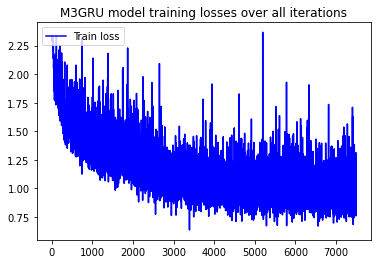

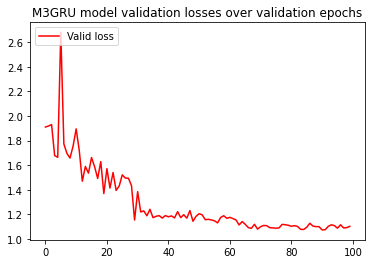

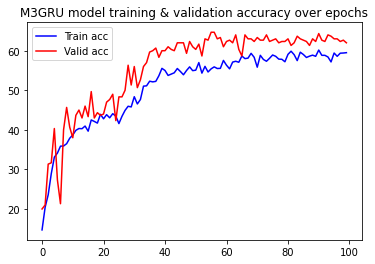

In [46]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M3GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M3GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M3GRU model training & validation accuracy over epochs")
plt.show()

In [47]:
M3GRU_test_acc_result, y_pred, y_true = test(model_M3GRU, n_layers=3)
print(M3GRU_test_acc_result)


Test set accuracy: 165/300 (55%)

55.0


Normalized confusion matrix


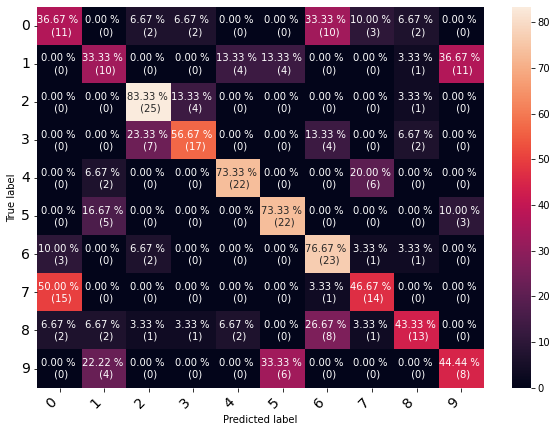

In [48]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

In [49]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [50]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.cpu().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].cpu().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [51]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [52]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
    #extracting the model features at the particular layer number
    layer = model_M3GRU.conv1
  
    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv1d):
    #getting the weight tensor data
        weight_tensor = layer.weight.data
        print(single_channel)
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor);
            else:
                plot_filters_single_channel(weight_tensor);
        
        else:
            if weight_tensor.shape[1] == 1:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")

In [53]:
model_M3GRU.conv1.weight.shape

torch.Size([6, 1, 160])

True


TypeError: Invalid shape (160,) for image data

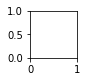

In [54]:
plot_weights(model_M3GRU, 0, single_channel = True)

## M5GRU Train

In [74]:
#M5GRU train & validate
log_interval = 20


pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M5GRU.parameters(), lr=0.01, weight_decay=0.004)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=32, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_M5GRU, epoch, log_interval, n_layers=5)
        validate(model_M5GRU, epoch, n_layers=5)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 0.366450	Accuracy: 28/2400 (1%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 0.681807	Accuracy: 460/2400 (19%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 0.804377	Accuracy: 887/2400 (37%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 0.954093	Accuracy: 1324/2400 (55%)

Validation Epoch: 1 	Loss: 0.822711	Accuracy: 175/300 (58%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 1.024307	Accuracy: 18/2400 (1%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 1.204638	Accuracy: 444/2400 (18%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 0.755946	Accuracy: 865/2400 (36%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 0.824449	Accuracy: 1308/2400 (54%)

Validation Epoch: 2 	Loss: 0.827861	Accuracy: 194/300 (65%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 0.695613	Accuracy: 27/2400 (1%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 0.901576	Accuracy: 449/2400 (19%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 0.880213	Accuracy: 876/2400 (36%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 0.787068	Accuracy: 1293/2400 (54%)

Validation Epoch:

Train Epoch: 24 [1920/2400 (80%)]	Loss: 0.711822	Accuracy: 1310/2400 (55%)

Validation Epoch: 24 	Loss: 1.389271	Accuracy: 177/300 (59%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 0.887989	Accuracy: 23/2400 (1%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 0.701085	Accuracy: 484/2400 (20%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 0.641049	Accuracy: 942/2400 (39%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 0.632225	Accuracy: 1416/2400 (59%)

Validation Epoch: 25 	Loss: 1.596955	Accuracy: 182/300 (61%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 0.888856	Accuracy: 24/2400 (1%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 1.050289	Accuracy: 470/2400 (20%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 0.731071	Accuracy: 922/2400 (38%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 1.079076	Accuracy: 1350/2400 (56%)

Validation Epoch: 26 	Loss: 1.125455	Accuracy: 195/300 (65%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 1.063893	Accuracy: 21/2400 (1%)
Train Epoch: 27 [640/2400 (27%)]	Loss: 0.651329	Accuracy: 459/2400 (19%)
Train Epoch: 27

Train Epoch: 48 [0/2400 (0%)]	Loss: 0.436538	Accuracy: 30/2400 (1%)
Train Epoch: 48 [640/2400 (27%)]	Loss: 0.376845	Accuracy: 563/2400 (23%)
Train Epoch: 48 [1280/2400 (53%)]	Loss: 0.448055	Accuracy: 1112/2400 (46%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 0.509445	Accuracy: 1662/2400 (69%)

Validation Epoch: 48 	Loss: 0.527845	Accuracy: 257/300 (86%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 0.563651	Accuracy: 27/2400 (1%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 0.491739	Accuracy: 574/2400 (24%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 0.405703	Accuracy: 1116/2400 (46%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 0.558392	Accuracy: 1650/2400 (69%)

Validation Epoch: 49 	Loss: 0.517199	Accuracy: 249/300 (83%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 0.789170	Accuracy: 23/2400 (1%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 0.602081	Accuracy: 532/2400 (22%)
Train Epoch: 50 [1280/2400 (53%)]	Loss: 0.604586	Accuracy: 1070/2400 (45%)
Train Epoch: 50 [1920/2400 (80%)]	Loss: 0.360321	Accuracy: 1619/2400 (67%)



Train Epoch: 71 [1280/2400 (53%)]	Loss: 0.493674	Accuracy: 1144/2400 (48%)
Train Epoch: 71 [1920/2400 (80%)]	Loss: 0.410590	Accuracy: 1707/2400 (71%)

Validation Epoch: 71 	Loss: 0.443305	Accuracy: 253/300 (84%)

Train Epoch: 72 [0/2400 (0%)]	Loss: 0.288412	Accuracy: 31/2400 (1%)
Train Epoch: 72 [640/2400 (27%)]	Loss: 0.483558	Accuracy: 599/2400 (25%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 0.761107	Accuracy: 1155/2400 (48%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 0.623749	Accuracy: 1697/2400 (71%)

Validation Epoch: 72 	Loss: 0.455506	Accuracy: 256/300 (85%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 0.417206	Accuracy: 28/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 0.488853	Accuracy: 587/2400 (24%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 0.387961	Accuracy: 1144/2400 (48%)
Train Epoch: 73 [1920/2400 (80%)]	Loss: 0.437733	Accuracy: 1705/2400 (71%)

Validation Epoch: 73 	Loss: 0.456058	Accuracy: 258/300 (86%)

Train Epoch: 74 [0/2400 (0%)]	Loss: 0.525055	Accuracy: 28/2400 (1%)
Train Epoch


Validation Epoch: 94 	Loss: 0.438677	Accuracy: 255/300 (85%)

Train Epoch: 95 [0/2400 (0%)]	Loss: 0.523213	Accuracy: 27/2400 (1%)
Train Epoch: 95 [640/2400 (27%)]	Loss: 0.387253	Accuracy: 583/2400 (24%)
Train Epoch: 95 [1280/2400 (53%)]	Loss: 0.469500	Accuracy: 1131/2400 (47%)
Train Epoch: 95 [1920/2400 (80%)]	Loss: 0.395597	Accuracy: 1696/2400 (71%)

Validation Epoch: 95 	Loss: 0.445554	Accuracy: 257/300 (86%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 0.480080	Accuracy: 27/2400 (1%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 0.414409	Accuracy: 586/2400 (24%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 0.631121	Accuracy: 1137/2400 (47%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 0.523214	Accuracy: 1690/2400 (70%)

Validation Epoch: 96 	Loss: 0.429814	Accuracy: 258/300 (86%)

Train Epoch: 97 [0/2400 (0%)]	Loss: 0.620274	Accuracy: 25/2400 (1%)
Train Epoch: 97 [640/2400 (27%)]	Loss: 0.566993	Accuracy: 587/2400 (24%)
Train Epoch: 97 [1280/2400 (53%)]	Loss: 0.424118	Accuracy: 1141/2400 (48%)
Train Epoch: 

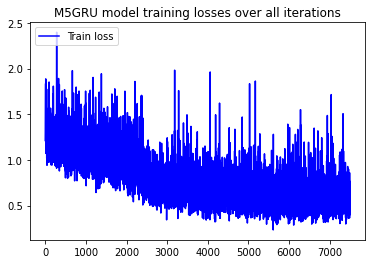

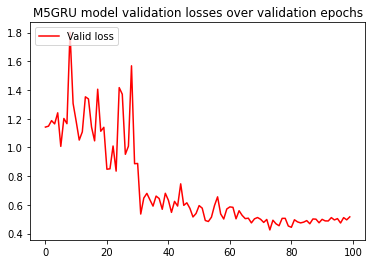

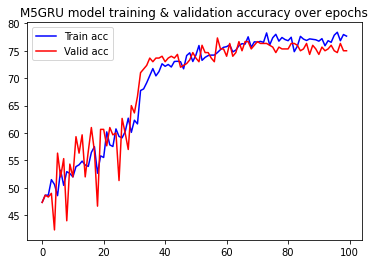

In [71]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M5GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M5GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M5GRU model training & validation accuracy over epochs")
plt.show()

In [72]:
M5GRU_test_acc_result, y_pred, y_true = test(model_M5GRU, n_layers=5)
print(M5GRU_test_acc_result)


Test set accuracy: 200/300 (67%)

66.66666666666667


Normalized confusion matrix


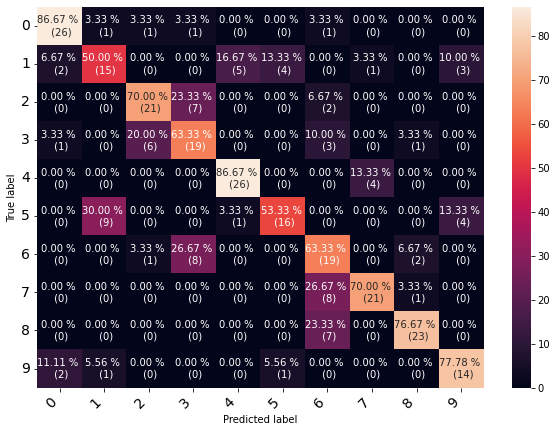

In [73]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## M11GRU Train

In [59]:
#M11GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M11GRU.parameters(), lr=0.01, weight_decay=0.007)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=33, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_M11GRU, epoch, log_interval, n_layers=11)
        validate(model_M11GRU, epoch, n_layers=11)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.324651	Accuracy: 4/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.301327	Accuracy: 70/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.319661	Accuracy: 143/2400 (6%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 2.288850	Accuracy: 239/2400 (10%)

Validation Epoch: 1 	Loss: 2.431119	Accuracy: 30/300 (10%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 2.215125	Accuracy: 7/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 2.340641	Accuracy: 93/2400 (4%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 2.225976	Accuracy: 186/2400 (8%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 2.154815	Accuracy: 298/2400 (12%)

Validation Epoch: 2 	Loss: 2.307637	Accuracy: 34/300 (11%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 2.236323	Accuracy: 5/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 2.196425	Accuracy: 126/2400 (5%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 2.384263	Accuracy: 247/2400 (10%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 2.067544	Accuracy: 360/2400 (15%)

Validation Epoch: 3 	Loss: 2.445

Train Epoch: 25 [640/2400 (27%)]	Loss: 1.761939	Accuracy: 145/2400 (6%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 1.792258	Accuracy: 283/2400 (12%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.822999	Accuracy: 427/2400 (18%)

Validation Epoch: 25 	Loss: 2.795620	Accuracy: 32/300 (11%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 1.796771	Accuracy: 4/2400 (0%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 2.074525	Accuracy: 145/2400 (6%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 1.815887	Accuracy: 262/2400 (11%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 1.646589	Accuracy: 424/2400 (18%)

Validation Epoch: 26 	Loss: 2.943153	Accuracy: 30/300 (10%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 1.806134	Accuracy: 6/2400 (0%)
Train Epoch: 27 [640/2400 (27%)]	Loss: 1.798421	Accuracy: 148/2400 (6%)
Train Epoch: 27 [1280/2400 (53%)]	Loss: 1.857380	Accuracy: 299/2400 (12%)
Train Epoch: 27 [1920/2400 (80%)]	Loss: 1.880413	Accuracy: 431/2400 (18%)

Validation Epoch: 27 	Loss: 3.101311	Accuracy: 30/300 (10%)

Train Epoch: 28 [0/2

Train Epoch: 49 [640/2400 (27%)]	Loss: 1.792076	Accuracy: 193/2400 (8%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 1.611180	Accuracy: 365/2400 (15%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 1.632652	Accuracy: 542/2400 (23%)

Validation Epoch: 49 	Loss: 3.185679	Accuracy: 30/300 (10%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 1.854909	Accuracy: 9/2400 (0%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 1.640230	Accuracy: 178/2400 (7%)
Train Epoch: 50 [1280/2400 (53%)]	Loss: 1.585258	Accuracy: 356/2400 (15%)
Train Epoch: 50 [1920/2400 (80%)]	Loss: 1.619139	Accuracy: 550/2400 (23%)

Validation Epoch: 50 	Loss: 3.203679	Accuracy: 30/300 (10%)

Train Epoch: 51 [0/2400 (0%)]	Loss: 1.726485	Accuracy: 6/2400 (0%)
Train Epoch: 51 [640/2400 (27%)]	Loss: 1.600249	Accuracy: 165/2400 (7%)
Train Epoch: 51 [1280/2400 (53%)]	Loss: 1.607031	Accuracy: 337/2400 (14%)
Train Epoch: 51 [1920/2400 (80%)]	Loss: 1.587632	Accuracy: 520/2400 (22%)

Validation Epoch: 51 	Loss: 3.198955	Accuracy: 30/300 (10%)

Train Epoch: 52 [0/2

Train Epoch: 73 [640/2400 (27%)]	Loss: 1.519272	Accuracy: 205/2400 (9%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 1.598691	Accuracy: 401/2400 (17%)
Train Epoch: 73 [1920/2400 (80%)]	Loss: 1.621760	Accuracy: 591/2400 (25%)

Validation Epoch: 73 	Loss: 3.324002	Accuracy: 30/300 (10%)

Train Epoch: 74 [0/2400 (0%)]	Loss: 1.645664	Accuracy: 11/2400 (0%)
Train Epoch: 74 [640/2400 (27%)]	Loss: 1.475458	Accuracy: 194/2400 (8%)
Train Epoch: 74 [1280/2400 (53%)]	Loss: 1.494542	Accuracy: 402/2400 (17%)
Train Epoch: 74 [1920/2400 (80%)]	Loss: 1.542971	Accuracy: 589/2400 (25%)

Validation Epoch: 74 	Loss: 3.324977	Accuracy: 30/300 (10%)

Train Epoch: 75 [0/2400 (0%)]	Loss: 1.775899	Accuracy: 11/2400 (0%)
Train Epoch: 75 [640/2400 (27%)]	Loss: 1.591927	Accuracy: 189/2400 (8%)
Train Epoch: 75 [1280/2400 (53%)]	Loss: 1.562621	Accuracy: 394/2400 (16%)
Train Epoch: 75 [1920/2400 (80%)]	Loss: 1.528032	Accuracy: 577/2400 (24%)

Validation Epoch: 75 	Loss: 3.324219	Accuracy: 30/300 (10%)

Train Epoch: 76 [0

Train Epoch: 97 [640/2400 (27%)]	Loss: 1.538516	Accuracy: 201/2400 (8%)
Train Epoch: 97 [1280/2400 (53%)]	Loss: 1.614261	Accuracy: 391/2400 (16%)
Train Epoch: 97 [1920/2400 (80%)]	Loss: 1.558983	Accuracy: 585/2400 (24%)

Validation Epoch: 97 	Loss: 3.338496	Accuracy: 30/300 (10%)

Train Epoch: 98 [0/2400 (0%)]	Loss: 1.733879	Accuracy: 3/2400 (0%)
Train Epoch: 98 [640/2400 (27%)]	Loss: 1.640183	Accuracy: 202/2400 (8%)
Train Epoch: 98 [1280/2400 (53%)]	Loss: 1.586245	Accuracy: 410/2400 (17%)
Train Epoch: 98 [1920/2400 (80%)]	Loss: 1.465334	Accuracy: 576/2400 (24%)

Validation Epoch: 98 	Loss: 3.338592	Accuracy: 30/300 (10%)

Train Epoch: 99 [0/2400 (0%)]	Loss: 1.585196	Accuracy: 7/2400 (0%)
Train Epoch: 99 [640/2400 (27%)]	Loss: 1.577492	Accuracy: 221/2400 (9%)
Train Epoch: 99 [1280/2400 (53%)]	Loss: 1.553746	Accuracy: 402/2400 (17%)
Train Epoch: 99 [1920/2400 (80%)]	Loss: 1.618932	Accuracy: 591/2400 (25%)

Validation Epoch: 99 	Loss: 3.342158	Accuracy: 30/300 (10%)

Train Epoch: 100 [0/

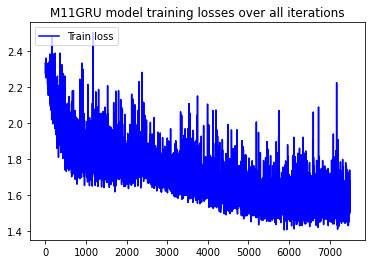

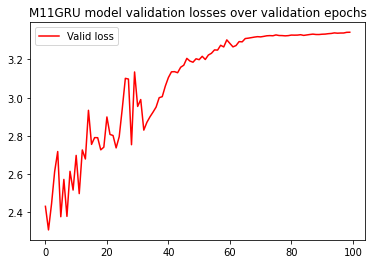

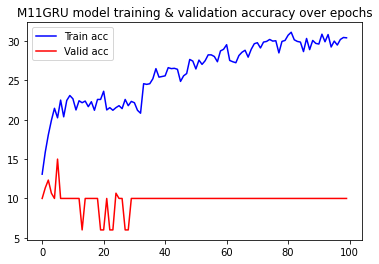

In [60]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M11GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M11GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M11GRU model training & validation accuracy over epochs")
plt.show()

In [61]:
M11GRU_test_acc_result, y_pred, y_true = test(model_M11GRU, n_layers=11)
print(M11GRU_test_acc_result)


Test set accuracy: 30/300 (10%)

10.0


Normalized confusion matrix


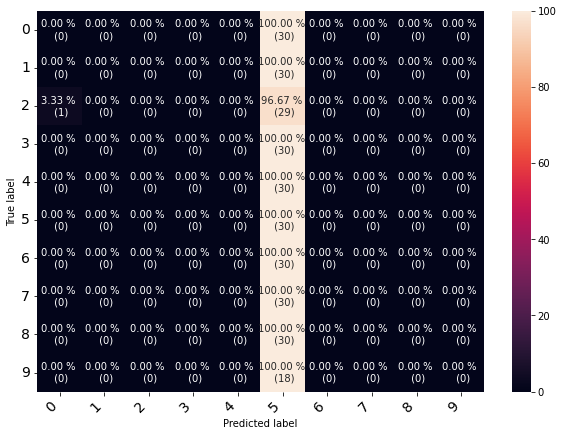

In [62]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

## M18GRU Train

In [65]:
#M18GRU train & validate
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses_train = []
losses_validation = []
accuracy_train = []
accuracy_validation = []

optimiser = optim.Adam(model_M18GRU.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=30, gamma=0.1)

transform = transform.to(device)
with tqdm(total=epoch_count) as pbar:
    for epoch in range(1, epoch_count + 1):
        train(model_M18GRU, epoch, log_interval, n_layers=18)
        validate(model_M18GRU, epoch, n_layers=18)
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/2400 (0%)]	Loss: 2.308407	Accuracy: 3/2400 (0%)
Train Epoch: 1 [640/2400 (27%)]	Loss: 2.323750	Accuracy: 75/2400 (3%)
Train Epoch: 1 [1280/2400 (53%)]	Loss: 2.302975	Accuracy: 141/2400 (6%)
Train Epoch: 1 [1920/2400 (80%)]	Loss: 2.304034	Accuracy: 203/2400 (8%)

Validation Epoch: 1 	Loss: 2.283432	Accuracy: 30/300 (10%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 2.278549	Accuracy: 5/2400 (0%)
Train Epoch: 2 [640/2400 (27%)]	Loss: 2.280961	Accuracy: 88/2400 (4%)
Train Epoch: 2 [1280/2400 (53%)]	Loss: 2.197265	Accuracy: 191/2400 (8%)
Train Epoch: 2 [1920/2400 (80%)]	Loss: 2.192354	Accuracy: 302/2400 (13%)

Validation Epoch: 2 	Loss: 2.324731	Accuracy: 42/300 (14%)

Train Epoch: 3 [0/2400 (0%)]	Loss: 2.196164	Accuracy: 2/2400 (0%)
Train Epoch: 3 [640/2400 (27%)]	Loss: 2.231716	Accuracy: 108/2400 (4%)
Train Epoch: 3 [1280/2400 (53%)]	Loss: 2.307205	Accuracy: 207/2400 (9%)
Train Epoch: 3 [1920/2400 (80%)]	Loss: 2.112617	Accuracy: 314/2400 (13%)

Validation Epoch: 3 	Loss: 2.10351


Validation Epoch: 24 	Loss: 1.997513	Accuracy: 54/300 (18%)

Train Epoch: 25 [0/2400 (0%)]	Loss: 1.911358	Accuracy: 5/2400 (0%)
Train Epoch: 25 [640/2400 (27%)]	Loss: 1.838315	Accuracy: 136/2400 (6%)
Train Epoch: 25 [1280/2400 (53%)]	Loss: 1.950970	Accuracy: 243/2400 (10%)
Train Epoch: 25 [1920/2400 (80%)]	Loss: 1.852284	Accuracy: 373/2400 (16%)

Validation Epoch: 25 	Loss: 2.327029	Accuracy: 48/300 (16%)

Train Epoch: 26 [0/2400 (0%)]	Loss: 1.799488	Accuracy: 4/2400 (0%)
Train Epoch: 26 [640/2400 (27%)]	Loss: 2.064125	Accuracy: 121/2400 (5%)
Train Epoch: 26 [1280/2400 (53%)]	Loss: 2.050836	Accuracy: 231/2400 (10%)
Train Epoch: 26 [1920/2400 (80%)]	Loss: 2.308550	Accuracy: 342/2400 (14%)

Validation Epoch: 26 	Loss: 2.114580	Accuracy: 61/300 (20%)

Train Epoch: 27 [0/2400 (0%)]	Loss: 2.258389	Accuracy: 4/2400 (0%)
Train Epoch: 27 [640/2400 (27%)]	Loss: 1.909078	Accuracy: 143/2400 (6%)
Train Epoch: 27 [1280/2400 (53%)]	Loss: 2.007016	Accuracy: 266/2400 (11%)
Train Epoch: 27 [1920/2400 

Train Epoch: 48 [1280/2400 (53%)]	Loss: 1.711920	Accuracy: 323/2400 (13%)
Train Epoch: 48 [1920/2400 (80%)]	Loss: 1.652453	Accuracy: 493/2400 (21%)

Validation Epoch: 48 	Loss: 1.788997	Accuracy: 74/300 (25%)

Train Epoch: 49 [0/2400 (0%)]	Loss: 1.679943	Accuracy: 9/2400 (0%)
Train Epoch: 49 [640/2400 (27%)]	Loss: 1.693840	Accuracy: 144/2400 (6%)
Train Epoch: 49 [1280/2400 (53%)]	Loss: 1.696308	Accuracy: 316/2400 (13%)
Train Epoch: 49 [1920/2400 (80%)]	Loss: 1.792271	Accuracy: 489/2400 (20%)

Validation Epoch: 49 	Loss: 1.717155	Accuracy: 76/300 (25%)

Train Epoch: 50 [0/2400 (0%)]	Loss: 1.706040	Accuracy: 9/2400 (0%)
Train Epoch: 50 [640/2400 (27%)]	Loss: 1.763363	Accuracy: 186/2400 (8%)
Train Epoch: 50 [1280/2400 (53%)]	Loss: 1.700116	Accuracy: 361/2400 (15%)
Train Epoch: 50 [1920/2400 (80%)]	Loss: 1.739492	Accuracy: 534/2400 (22%)

Validation Epoch: 50 	Loss: 1.754549	Accuracy: 77/300 (26%)

Train Epoch: 51 [0/2400 (0%)]	Loss: 1.734379	Accuracy: 9/2400 (0%)
Train Epoch: 51 [640/2400

Train Epoch: 72 [640/2400 (27%)]	Loss: 1.578994	Accuracy: 220/2400 (9%)
Train Epoch: 72 [1280/2400 (53%)]	Loss: 1.711183	Accuracy: 439/2400 (18%)
Train Epoch: 72 [1920/2400 (80%)]	Loss: 1.497093	Accuracy: 631/2400 (26%)

Validation Epoch: 72 	Loss: 1.757909	Accuracy: 70/300 (23%)

Train Epoch: 73 [0/2400 (0%)]	Loss: 1.555007	Accuracy: 13/2400 (1%)
Train Epoch: 73 [640/2400 (27%)]	Loss: 1.494218	Accuracy: 234/2400 (10%)
Train Epoch: 73 [1280/2400 (53%)]	Loss: 1.682469	Accuracy: 450/2400 (19%)
Train Epoch: 73 [1920/2400 (80%)]	Loss: 1.699770	Accuracy: 671/2400 (28%)

Validation Epoch: 73 	Loss: 1.792199	Accuracy: 75/300 (25%)

Train Epoch: 74 [0/2400 (0%)]	Loss: 1.577413	Accuracy: 10/2400 (0%)
Train Epoch: 74 [640/2400 (27%)]	Loss: 1.547165	Accuracy: 211/2400 (9%)
Train Epoch: 74 [1280/2400 (53%)]	Loss: 1.640919	Accuracy: 432/2400 (18%)
Train Epoch: 74 [1920/2400 (80%)]	Loss: 1.453098	Accuracy: 646/2400 (27%)

Validation Epoch: 74 	Loss: 1.648979	Accuracy: 82/300 (27%)

Train Epoch: 75 [

Train Epoch: 95 [1920/2400 (80%)]	Loss: 1.521210	Accuracy: 671/2400 (28%)

Validation Epoch: 95 	Loss: 1.766438	Accuracy: 80/300 (27%)

Train Epoch: 96 [0/2400 (0%)]	Loss: 1.594150	Accuracy: 6/2400 (0%)
Train Epoch: 96 [640/2400 (27%)]	Loss: 1.486773	Accuracy: 226/2400 (9%)
Train Epoch: 96 [1280/2400 (53%)]	Loss: 1.641188	Accuracy: 438/2400 (18%)
Train Epoch: 96 [1920/2400 (80%)]	Loss: 1.628016	Accuracy: 684/2400 (28%)

Validation Epoch: 96 	Loss: 1.796164	Accuracy: 80/300 (27%)

Train Epoch: 97 [0/2400 (0%)]	Loss: 1.558547	Accuracy: 9/2400 (0%)
Train Epoch: 97 [640/2400 (27%)]	Loss: 1.652961	Accuracy: 224/2400 (9%)
Train Epoch: 97 [1280/2400 (53%)]	Loss: 1.520249	Accuracy: 445/2400 (19%)
Train Epoch: 97 [1920/2400 (80%)]	Loss: 1.647636	Accuracy: 660/2400 (28%)

Validation Epoch: 97 	Loss: 1.756997	Accuracy: 81/300 (27%)

Train Epoch: 98 [0/2400 (0%)]	Loss: 1.679343	Accuracy: 4/2400 (0%)
Train Epoch: 98 [640/2400 (27%)]	Loss: 1.329146	Accuracy: 230/2400 (10%)
Train Epoch: 98 [1280/2400

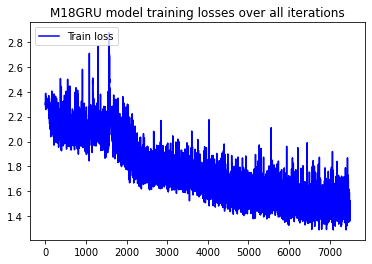

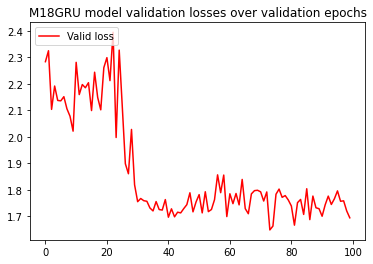

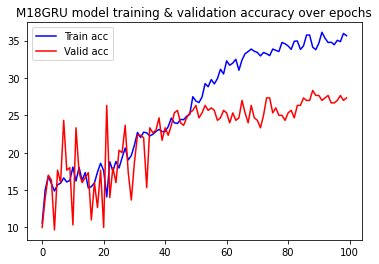

In [66]:
# Plot training loss
plt.plot(losses_train, 'b', label='Train loss')
plt.legend(loc="upper left")
plt.title("M18GRU model training losses over all iterations")
plt.show()

# Plot validation loss
plt.plot(losses_validation, 'r', label='Valid loss')
plt.legend(loc="upper left")
plt.title("M18GRU model validation losses over validation epochs")
plt.show()

# Plot accuracy
plt.plot(accuracy_train, 'b', label='Train acc')
plt.plot(accuracy_validation,'r', label ='Valid acc')
plt.legend(loc="upper left")
plt.title("M18GRU model training & validation accuracy over epochs")
plt.show()

In [67]:
M18GRU_test_acc_result, y_pred, y_true = test(model_M18GRU, n_layers=18)
print(M18GRU_test_acc_result)


Test set accuracy: 69/300 (23%)

23.0


Normalized confusion matrix


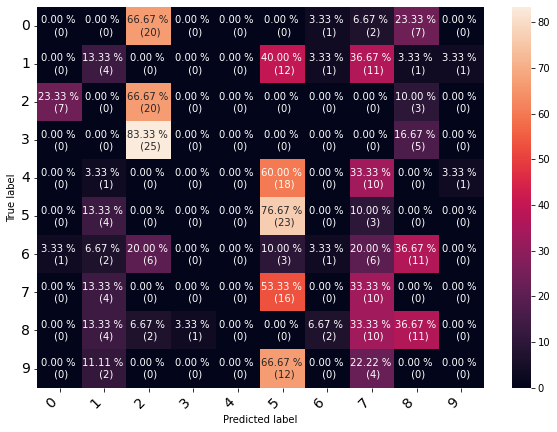

In [68]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names = numclasses)

In [69]:
print('Number of epochs:', epoch_count)
print(f"\nM3GRU model accuracy: {(M3GRU_test_acc_result):.0f}%")
print(f"M5GRU model accuracy: {(M5GRU_test_acc_result):.0f}%")
print(f"M11GRU model accuracy: {(M11GRU_test_acc_result):.0f}%")
print(f"M18GRU model accuracy: {(M18GRU_test_acc_result):.0f}%")

Number of epochs: 100

M3GRU model accuracy: 55%
M5GRU model accuracy: 49%
M11GRU model accuracy: 10%
M18GRU model accuracy: 23%
